# Section 1: Preparing the Data

## Import Statements

In [1]:
!pip install tensorflow
!pip install gensim
!pip install tf-keras


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow as tf

from gensim.models import Word2Vec
from gensim.models import LsiModel
import gensim

import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sentence_transformers import SentenceTransformer
import json
import contractions
import random

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import copy
import statistics

/Users/jadeynfeng/Documents/GitHub/Hons24-Jadeyn/venv/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/Users/jadeynfeng/Documents/GitHub/Hons24-Jadeyn/venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Helper Functions for Preparing Data

In [4]:
def pad_sequence(dset, max_len=None):
    if not max_len:
        max_len = len(max(dset, key=len))
    print("max length of MWO:", max_len)
    for i in range(len(dset)):
        count = 0
        while len(dset[i]) < max_len:
            dset[i].append(dset[i][count])
            count+=1
    return dset

In [5]:
def clean_tokens(tokens):
    """cleans tokens by removing stopwords and expanding contractions"""
    stopwords =["<num>", "<id>", "-"]
    tokens = [i for i in tokens if i not in stopwords]
    tokens = contractions.fix(" ".join(tokens)).split()
    return tokens

In [6]:
def extract_function_from_entity_index(row, index, equipment_dict=None):
    """extracts the function from an PhysicalObject's index"""
    if equipment_dict:
        start = row["entities"][index]["start"]
        end = row["entities"][index]["end"]
        equipment = " ".join([row["tokens"][i] for i in range(start, end)])
        if equipment not in equipment_dict.keys():
            return None
        return equipment_dict[equipment][:-6].lower()
    types = row["entities"][index]["type"].split("/")
    if len(types) > 1:
        return types[1][:-6].lower()
    else:
        return None
    
def get_inherent_function(row, equipment_dict=None):
    """choose the most appropriate inherent function to do with the failure mode of a MWO"""
    # list of tuples of head and tail indices
    hasPart_heads = []
    hasPart_tails = []
    contains_heads =[]
    contains_tails =[]
    isA_relations_indices = []

    for r in row["relations"]:
        if r["type"] == "hasPart":
            hasPart_heads.append(r["head"])
            hasPart_tails.append(r["tail"])
        if r["type"] == "contains":
            contains_heads.append(r["head"])
            contains_tails.append(r["tail"])
        if r["type"] == "isA":
            isA_relations_indices.append((r["head"], r["tail"]))

    # remove any repeats
    hasPart_heads = list(set(hasPart_heads))
    hasPart_tails = list(set(hasPart_tails))
    
    # list of physical object indices not in a hasPart or isA relation
    physical_object_indices = []
    
    # get all physical object indices
    for i in range(len(row["entities"])):
        if row["entities"][i]["type"].split("/")[0] == "PhysicalObject" and (equipment_dict or len(row["entities"][i]["type"].split("/")) == 1 or (row["entities"][i]["type"].split("/")[1]  != "Substance")):
            physical_object_indices.append(i)
    
    inherent_function_index = []
    for i in hasPart_tails:
        # if tail is not a head of a hasPart relation
        if i not in hasPart_heads:
            inherent_function_index.append(i)
        # remove tail from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)
    
    for i in hasPart_heads:
        # remove head from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)

    for i in isA_relations_indices:
        # remove physical objects that are part of an isA relation
        if i[0] in physical_object_indices:
            physical_object_indices.remove(i[0])
        if i[1] in physical_object_indices:
            physical_object_indices.remove(i[1])

    # EXCEPTION 1: if there are physical objects that are not part of a hasPart or isA relation, and there is a hasPart relation
    if physical_object_indices and inherent_function_index:
        # in general, ignore additional physical objects 
        if len(inherent_function_index) ==1:
            isA_tails = [i[1] for i in isA_relations_indices]
            # if there is a more specific (head) object in an isA relation
            if inherent_function_index[0] in isA_tails:
                isA_head_index = isA_relations_indices[isA_tails.index(inherent_function_index[0])][0]
                func = extract_function_from_entity_index(row, isA_head_index, equipment_dict)
                return func
            else:
                func = extract_function_from_entity_index(row, inherent_function_index[0], equipment_dict)
                return func


    # EXCEPTION 2: if there is zero or more than one physical object and no hasPart relations
    if (len(inherent_function_index) == 0) and len(physical_object_indices)!=1 and not isA_relations_indices:
        # if there are no physical objects, remove the row
        if len(physical_object_indices) == 0:
            print("remove:",row, "\n")
            return None
        physical_object_not_substance = []
        for i in physical_object_indices:
            start = row["entities"][i]["start"]
            end = row["entities"][i]["end"]
            # if the physical object is not a substance
            if end == len(row["tokens"]) and " ".join(row["tokens"][start:]) != "oil":
                physical_object_not_substance.append(i)
            elif " ".join(row["tokens"][start:end]) != "oil":
                physical_object_not_substance.append(i)

        # if there is only one non-substance physical object, extract its function
        if len(physical_object_not_substance) == 1:
            func = extract_function_from_entity_index(row, physical_object_not_substance[0], equipment_dict)
            return func
        else:
            func = extract_function_from_entity_index(row, physical_object_indices[0], equipment_dict)
            return func
            
                

    # EXCEPTION 3: if there are more than one leftover tail from hasPart relations
    if (len(inherent_function_index) > 1):
        # manually assign inherent function
        if row["text"] == "replace unserviceable transmission screen and magnet":
            return "transforming"
        elif row["text"] == "pump drive box coupling and shaft unserviceable":
            return "driving"
        else:
            return None
    

    # get entities
    if len(inherent_function_index) == 1 and len(physical_object_indices) == 0:
        func = extract_function_from_entity_index(row, inherent_function_index[0], equipment_dict)
        return func
    elif len(inherent_function_index) == 0 and len(physical_object_indices) == 1:
        func = extract_function_from_entity_index(row, physical_object_indices[0], equipment_dict)
        return func
    elif all(i in [x for xs in isA_relations_indices for x in xs] for i in physical_object_indices):
        isA_heads = [i[0] for i in isA_relations_indices]
        isA_tails = [i[1] for i in isA_relations_indices]
        isA_specific_indices = []
        for i in isA_heads:
            if i not in isA_tails:
                isA_specific_indices.append(i)
        if len(isA_specific_indices) == 1:
            func = extract_function_from_entity_index(row, isA_specific_indices[0], equipment_dict)
            return func
        
        else:
            if row["text"] == "<id> park brake alarm fault":
                return "restricting"
            else:
                return None
               
    elif len(inherent_function_index)>1:
        return None
       
    else:
        return None
        
    
    

def get_gold_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    """get the gold dataset and its inherent function labels"""
    f = open("../data/gold_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()


    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            inherent_function = get_inherent_function(datum)
            if not inherent_function:
                continue

            tokens = datum["tokens"].copy()

            # remove activity tokens
            if "Activity" in types:
                activity_indices = []
                for e in datum["entities"]:
                    if e["type"].split("/")[0] == "Activity":
                        for i in range(e["start"], e["end"]):
                            activity_indices.append(i)
                activity_indices = sorted(set(activity_indices), reverse=True)
                for i in activity_indices:
                    tokens.pop(i)
                

            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            # add state, equipment, and inherent function to dictionary with key MWO
            mwo = " ".join(tokens)
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                for i in range(len(types)):
                    if types[i] in ["State", "Process", "Property"]:
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        states.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                    elif types[i] == "PhysicalObject":
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        equip.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]

    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()
    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO

In [7]:
def create_equipment_dictionary():
    """create a dictionary of known equipment and their inherent functions"""
    f = open("../data/gold_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    
    # exception multiple types for the same equipment
    ignored_equipment = {"auto-lube":"ProtectingObject", "axle":"GuidingObject", "drag":"MatterProcessingObject", "universal joint":"GuidingObject", "adaptor":"InterfacingObject", "batteries":"StoringObject", "carousel":"StoringObject", "window":"RestrictingObject", "shaft":"GuidingObject", "input shaft":"GuidingObject"}
    equipment = ignored_equipment.copy()
    
    for datum in data:
        for e in datum["entities"]:
            entity_type = e["type"].split("/")
            if entity_type[0] == "PhysicalObject" and len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
                start = int(e["start"])
                end = int(e["end"])
                equipment_text = " ".join([datum["tokens"][t] for t in range(start, end)])
                
                if equipment_text in ignored_equipment:
                    continue
                if equipment_text not in equipment:
                    equipment[equipment_text] = entity_type[1]
              
    return equipment

def get_synthetic_dataset(filename, dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    """Get synthetic dataset and its inherent function labels"""
    import csv


    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        counter = 0
        for row in csvreader:
            tokens = row[0].split()
            if len(row[1].split("/")) == 1 or row[1].split("/")[1] in ["Substance", "Organism", "GuidingObject","HoldingObject"] or "leak" in row[3]:
                counter+=1
                continue
            inherent_function = row[1].split("/")[1][:-6].lower()

            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            mwo= " ".join(tokens)
            # add state, equipment, inherent function to dictionary with key tokens
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                states.append(row[3])
                equip.append(row[2])
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]

    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()

    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO
            
    
def get_silver_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    """get the silver dataset and its inherent function labels"""
    equipment_dict = create_equipment_dictionary()
    
    f = open("../data/silver_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            inherent_function = get_inherent_function(datum, equipment_dict)
            if not inherent_function:
                continue
            
            tokens = datum["tokens"].copy()

            # remove activity tokens
            if "Activity" in types:
                activity_indices = []
                for e in datum["entities"]:
                    if e["type"].split("/")[0] == "Activity":
                        for i in range(e["start"], e["end"]):
                            activity_indices.append(i)
                activity_indices = sorted(set(activity_indices), reverse=True)
                for i in activity_indices:
                    tokens.pop(i)
            
            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            mwo= " ".join(tokens)
            # add state, equipment, inherent function to dictionary with key tokens
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                for i in range(len(types)):
                    if types[i] in ["State", "Process", "Property"]:
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        states.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                    elif types[i] == "PhysicalObject":
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        equip.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]


    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()
    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO


## Create Dataset

In [8]:
def create_dataset():
    """create the dataset of gold, silver and synthetic data"""
    MWO_by_function = {}
    dataset = []
    labels = []
    class_list = []
    state_equipment_inherentfunction_by_MWO = {}

    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_gold_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)
    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_synthetic_dataset("../data/synthetic2.csv",dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)
    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_silver_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)

    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO


In [9]:
dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = create_dataset()

# remove information processing
for i in MWO_by_function["informationprocessing"]:
    if i in dataset:
        print("Removed")
        print(i)
        dataset.remove(i)
labels = [i for i in labels if i != 16] 

# divide dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, random_state=42, shuffle=True, test_size=0.2)
y_train = np.array(y_train)
y_test = np.array(y_test)
X = X_train + X_test

print("training set length:",len( X_train))
print("test set length:", len(X_test))
print("dataset length:",len( dataset))

remove: {'text': '<id> air leak', 'tokens': ['<id>', 'air', 'leak'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> - air leak', 'tokens': ['<id>', '-', 'air', 'leak'], 'entities': [{'start': 2, 'end': 3, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 3, 'end': 4, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> - fuel leak', 'tokens': ['<id>', '-', 'fuel', 'leak'], 'entities': [{'start': 2, 'end': 3, 'type': 'PhysicalObject/Substance/Liquid'}, {'start': 3, 'end': 4, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> <id> replace hydraulic oil leak text', 'tokens': ['<id>', '<id>', 'replace', 'hydraulic', 'oil', 

# Section 2: Creating Embeddings and Clustering Helper Functions

## Create Word2Vec and SBERT Embeddings

In [10]:
def w2v_embed(xtrain,xtest, max_len):
    """get Word2Vec embeddings for the dataset"""
    # Word2Vec embeddings as input
    x_copy_train = copy.deepcopy(xtrain)
    x_copy_test = copy.deepcopy(xtest)
    padded_x_train = pad_sequence(x_copy_train, max_len)
    padded_x_test = pad_sequence(x_copy_test, max_len)
    padded_x = padded_x_train + padded_x_test

    w2vmodel = gensim.models.Word2Vec(padded_x, min_count=1, vector_size=100,
                                    window=5, sg=1)


    w2v_embeddings_train = []
    for sentence in padded_x_train:
        row = []
        for word in sentence:
            row.append(w2vmodel.wv[word])
        w2v_embeddings_train.append(row)
    w2v_embeddings_train = np.array(w2v_embeddings_train)

    w2v_embeddings_test = []
    for sentence in padded_x_test:
        row = []
        for word in sentence:
            row.append(w2vmodel.wv[word])
        w2v_embeddings_test.append(row)
    w2v_embeddings_test = np.array(w2v_embeddings_test)
    return w2v_embeddings_train, w2v_embeddings_test

max_len = len(max(dataset, key=len))
w2v_embeddings_X_train, w2v_embeddings_X_test = w2v_embed(X_train, X_test, max_len)

print(w2v_embeddings_X_train.shape)
print(w2v_embeddings_X_test.shape)

max length of MWO: 10
max length of MWO: 10
(2520, 10, 100)
(631, 10, 100)


In [11]:
# SBERT embeddings
sbert = SentenceTransformer("all-mpnet-base-v2")
SBERT_embeddings_train = sbert.encode(X_train)
SBERT_embeddings_test = sbert.encode(X_test)

print(SBERT_embeddings_train.shape)
print(SBERT_embeddings_test.shape)

(2520, 768)
(631, 768)


## Clustering Helper Functions

In [12]:
def print_cluster_stats(all_inherentfunc_occurrences):
    """print statistics of the clusters"""
    # get top words    
    print()
    print()
    print("Ave number of documents per cluster:", sum([sum(i) for i in all_inherentfunc_occurrences])/len(all_inherentfunc_occurrences))
    print("Median number of documents per cluster:", statistics.median([sum(i) for i in all_inherentfunc_occurrences]))
    print("Min number of documents per cluster:", min([sum(i) for i in all_inherentfunc_occurrences]))
    print("Max number of documents per cluster:", max([sum(i) for i in all_inherentfunc_occurrences]))
    print()
    one_func = [i for i in all_inherentfunc_occurrences if i[0]/sum(i) >= 0.8]
    print("Percentage of clusters with 1 main Inherent function (80% of docs):", len(one_func)/len(all_inherentfunc_occurrences))

    two_three_func = [i for i in all_inherentfunc_occurrences if sum(i[:3])/sum(i) >= 0.8 and i[0]/sum(i) < 0.8]
    print("Percentage of clusters with 2 or 3 main Inherent functions (80% of docs):", len(two_three_func)/len(all_inherentfunc_occurrences))

    print("Percentage of documents in clusters with 1 main Inherent function (80% of docs):", sum(sum(one_func,[]))/len(dataset))
    print("Percentage of documents in clusters with 2 or 3 main Inherent functions (80% of docs):", sum(sum(two_three_func,[]))/len(dataset))

### K-means Clustering

In [19]:
def perform_kmeans(cluster_embeddings):
    # PCA reduction
    pca = PCA(n_components=2)
    pca_embedding = pca.fit_transform(cluster_embeddings)
    plt.scatter(pca_embedding[:,0], pca_embedding[:,1])
    plt.title("PCA")
    plt.show()

    # tsne reduction
    tsne = TSNE(n_components=2).fit_transform(cluster_embeddings)
    plt.scatter(tsne[:,0], tsne[:,1])
    plt.title("TSNE")
    plt.show()


    # Perform kmean clustering
    silhouette_scores = []
    test_k = list(range(5, 50))
    for i in test_k:
        print(i, "/", 50)
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=100).fit(cluster_embeddings)
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(cluster_embeddings, labels))
        if i == 16:
            nmi = normalized_mutual_info_score(labels, y_train.tolist()+y_test.tolist())
    plt.plot(test_k, silhouette_scores)
    plt.title("Silhouette Scores")
    plt.show()
    
    print("NMI:",nmi)


def run_kmeans_best_k(k, cluster_embeddings):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100).fit(cluster_embeddings)
    cluster_labels = kmeans.labels_
    all_inherentfunc_occurrences = []

    for i in range(1,k+1):
        print("Cluster",i,":")
        cluster_docs = []
        cluster_words = {}
        cluster_states={}
        cluster_equip={}
        cluster_inherentfunc={}
        for j in range(len(cluster_labels)):
            if cluster_labels[j]==(i-1):
                mwo = " ".join(X[j])
                cluster_docs.append(mwo)

                for word in X[j]:
                    if word in cluster_words:
                        cluster_words[word]+=1
                    else:
                        cluster_words[word]=1
                
                state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
                for state in state_equip_inherfunc[0]:
                    if state in cluster_states:
                        cluster_states[state]+=1
                    else:
                        cluster_states[state]=1
                for equip in state_equip_inherfunc[1]:
                    if equip in cluster_equip:
                        cluster_equip[equip]+=1
                    else:
                        cluster_equip[equip]=1
                if state_equip_inherfunc[2] in cluster_inherentfunc:
                    cluster_inherentfunc[state_equip_inherfunc[2]]+=1
                else:
                    cluster_inherentfunc[state_equip_inherfunc[2]]=1
        
        # get top words
        print("Cluster Size:=========", len(cluster_labels[cluster_labels==i-1]))
        print("Sample Docs:=========")
        if len(cluster_docs) > 0:
            for j in random.sample(cluster_docs, min(5, len(cluster_docs))):
                print(j)
        else:
            print("No docs")
        print()
        print("Top words:=========")
        sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
        for j in range(min(len(sorted_cluster_words), 5)):
            print(sorted_cluster_words[j])
        print()
        sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
        print("Top failure modes:=========")
        for j in range(min(len(sorted_cluster_states), 5)):
            print(sorted_cluster_states[j])
        print()

        sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
        print("Top equipment:=========")
        for j in range(min(len(sorted_cluster_equip), 5)):
            print(sorted_cluster_equip[j])
        print()

        sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
        inherentfunc_occurrences= []
        print("Inherent functions in order:")
        for j in range(len(sorted_cluster_inherentfunc)):
            sentence = sorted_cluster_inherentfunc[j] +" (" + str(cluster_inherentfunc[sorted_cluster_inherentfunc[j]]) +")"
            print(sentence)
            inherentfunc_occurrences.append(cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
        all_inherentfunc_occurrences.append(inherentfunc_occurrences)
        print("==================================================\n")

    print_cluster_stats(all_inherentfunc_occurrences)

### Hierarchical Clustering

In [29]:
def perform_hierarchical_clustering(cluster_embeddings, method):
    linkage_data = linkage(cluster_embeddings, method=method)
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(linkage_data)
    plt.show()

    # calculate sihouette score on different k values
    silhouette_scores = []
    test_k = list(range(5, 50))
    nmi = 0
    for i in test_k:
        cluster_labels = fcluster(linkage_data, i, criterion='maxclust')
        silhouette_scores.append(silhouette_score(cluster_embeddings, cluster_labels))
        if i == 16:
            nmi = normalized_mutual_info_score(cluster_labels, y_train.tolist()+y_test.tolist())
    plt.plot(test_k, silhouette_scores, marker='o')
    plt.title("Silhouette Scores")
    plt.show()

    print("NMI:",nmi)

    return linkage_data


def get_hierarchical_clusters(k, linkage_data):
    cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
    all_inherentfunc_occurrences = []
    for i in range(1,k+1):
        print("Cluster",i,":")
        cluster_docs = []
        cluster_words = {}
        cluster_states={}
        cluster_equip={}
        cluster_inherentfunc={}
        for j in range(len(cluster_labels)):
            if cluster_labels[j]==i:
                mwo = " ".join(X[j])
                cluster_docs.append(mwo)
                for word in X[j]:
                    if word in cluster_words:
                        cluster_words[word]+=1
                    else:
                        cluster_words[word]=1
        
                state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
                for state in state_equip_inherfunc[0]:
                    if state in cluster_states:
                        cluster_states[state]+=1
                    else:
                        cluster_states[state]=1
                for equip in state_equip_inherfunc[1]:
                    if equip in cluster_equip:
                        cluster_equip[equip]+=1
                    else:
                        cluster_equip[equip]=1
                if state_equip_inherfunc[2] in cluster_inherentfunc:
                    cluster_inherentfunc[state_equip_inherfunc[2]]+=1
                else:
                    cluster_inherentfunc[state_equip_inherfunc[2]]=1
        

        # get top words
        print("Cluster Size:=========", len(cluster_labels[cluster_labels==i]))
        print("Sample Docs:=========")
        if len(cluster_docs) > 0:
            for j in random.sample(cluster_docs, min(10, len(cluster_docs))):
                print(j)
        else:
            print("No docs")
        print()
        print("Top words:=========")
        sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
        for j in range(min(len(sorted_cluster_words), 5)):
            print(sorted_cluster_words[j])
        print()
        sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
        print("Top failure modes:=========")
        for j in range(min(len(sorted_cluster_states), 5)):
            print(sorted_cluster_states[j])
        print()

        sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
        print("Top equipment:=========")
        for j in range(min(len(sorted_cluster_equip), 5)):
            print(sorted_cluster_equip[j])
        print()

        sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
        inherentfunc_occurrences = []
        print("Inherent functions in order:")
        for j in range(len(sorted_cluster_inherentfunc)):
            sentence = sorted_cluster_inherentfunc[j] +" (" + str(cluster_inherentfunc[sorted_cluster_inherentfunc[j]]) +")"
            print(sentence)
            inherentfunc_occurrences.append(cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
        all_inherentfunc_occurrences.append(inherentfunc_occurrences)
        print("==================================================\n")
    
    print_cluster_stats(all_inherentfunc_occurrences)

# Section 3: Performing Experiments

## Approach 1: Word2Vec Clustering

In [15]:
w2v_embeddings_all = np.concatenate((w2v_embeddings_X_train, w2v_embeddings_X_test))
# get average vector for each sentence
w2v_embeddings_all = w2v_embeddings_all.mean(axis=1)
print(w2v_embeddings_all.shape)

(3151, 100)


### K-means Clustering

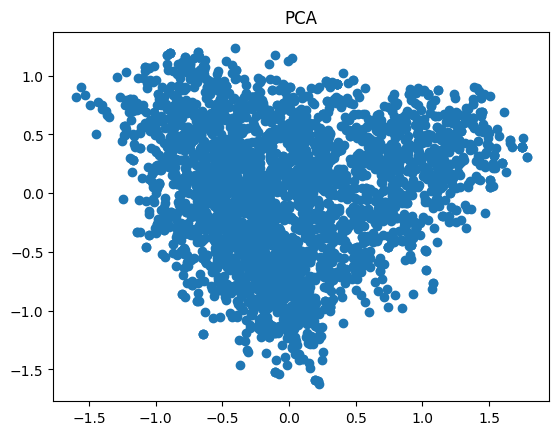

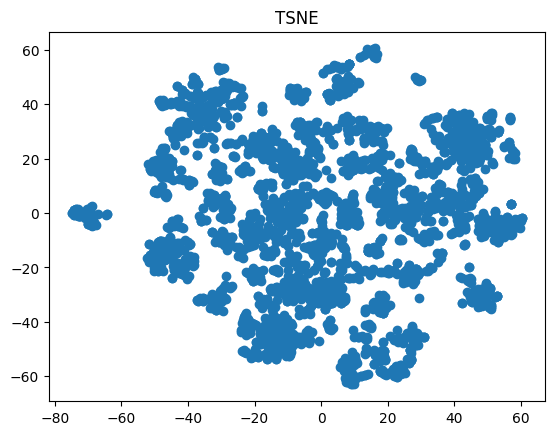

5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30
31 / 30
32 / 30
33 / 30
34 / 30
35 / 30
36 / 30
37 / 30
38 / 30
39 / 30
40 / 30
41 / 30
42 / 30
43 / 30
44 / 30
45 / 30
46 / 30
47 / 30
48 / 30
49 / 30


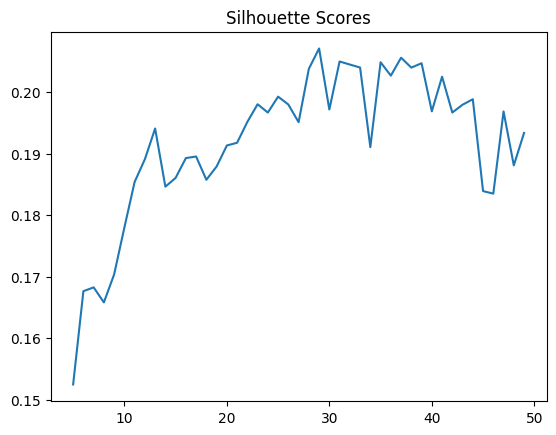

NMI: 0.24848111714400561


In [18]:
perform_kmeans(w2v_embeddings_all)

In [20]:
run_kmeans_best_k(29, w2v_embeddings_all)

Cluster 1 :
Cluster Size:========= 40
Sample Docs:=========
cracks in mud bucket
crack in boom chord
mud bucket has cracks
mud bucket is cracked
cracks on bucket

Top words:=========
cracks
in
bucket
mud
on

Top failure modes:=========
cracks
crack
missing
dent
requested

Top equipment:=========
bucket
mud bucket
handrail
boom
stick

Inherent functions in order:
storing (15)
holding (12)
protecting (6)
driving (3)
guiding (1)
interfacing (1)
covering (1)
controlling (1)

Cluster 2 :
Cluster Size:========= 95
Sample Docs:=========
camera fault
alternator fault
alternator fault
line undervoltage fault
ground fault in propel

Top words:=========
fault
transmission
in
propel
Tele-Remote

Top failure modes:=========
fault
slipping fault
electrical fault
ground fault
overcharging

Top equipment:=========
transmission
propel
Tele-Remote
alternator
generator

Inherent functions in order:
transforming (21)
generating (14)
driving (11)
protecting (8)
controlling (7)
humaninteraction (7)
holding 

### Average Hierarchical Clustering

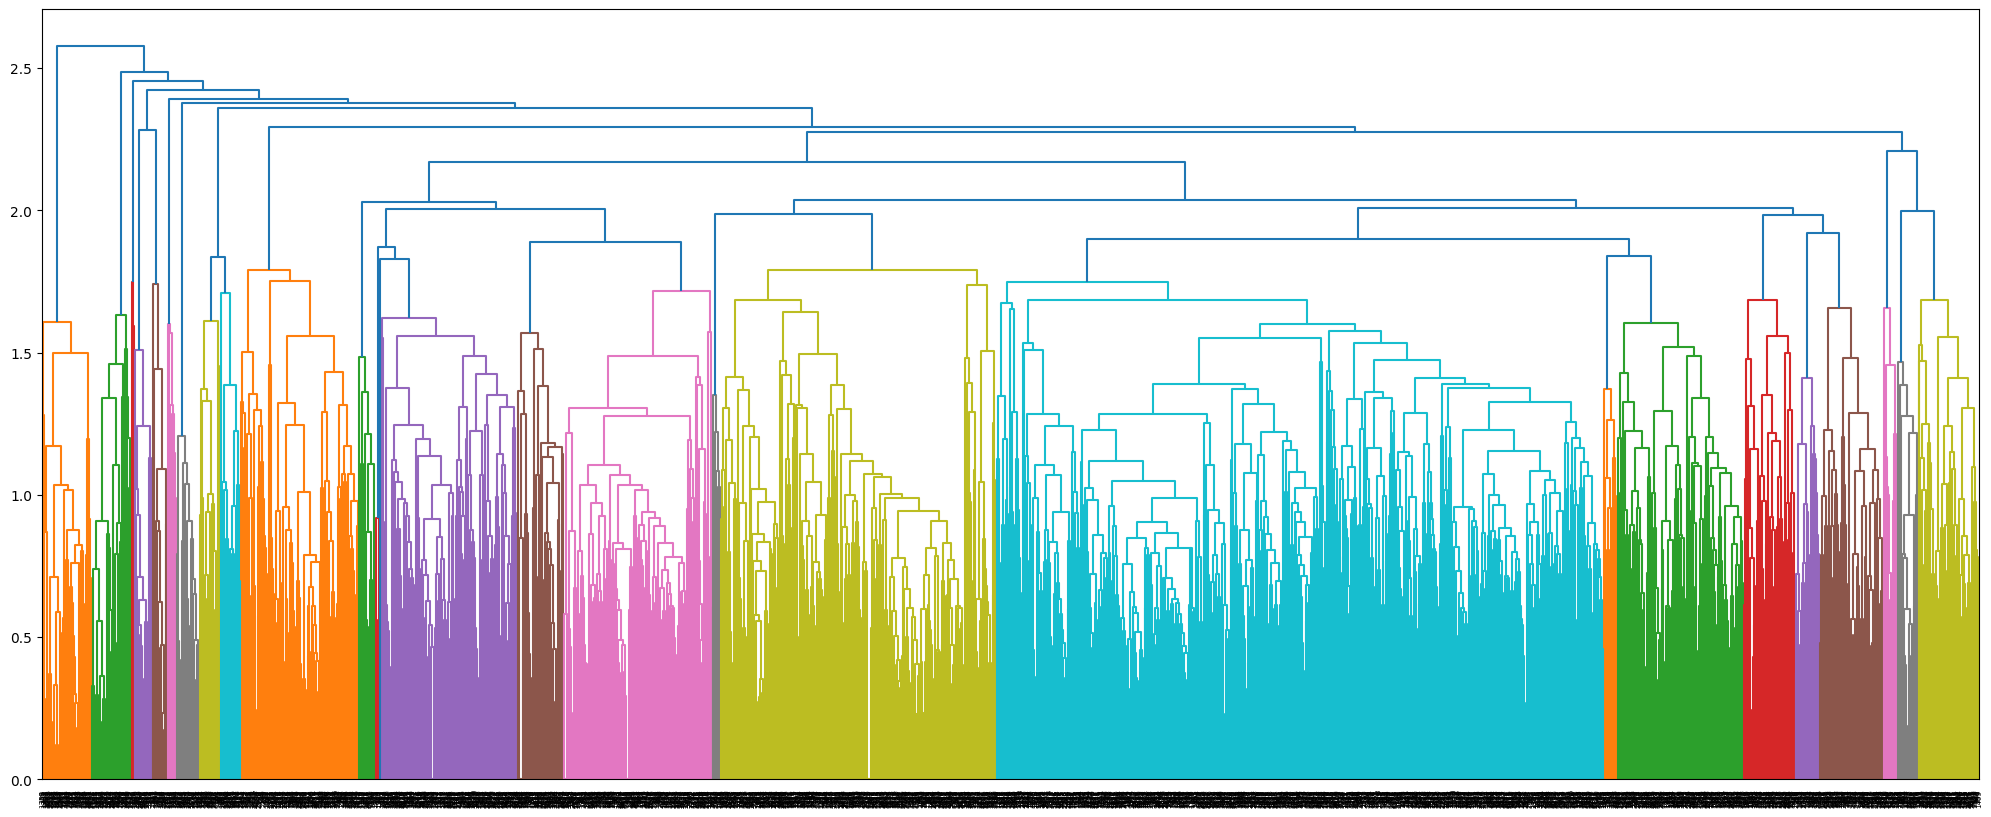

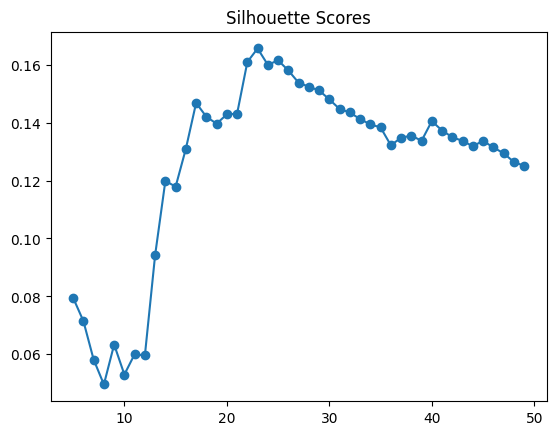

NMI: 0.2077598035804272


In [30]:
linkage_data_ave = perform_hierarchical_clustering(w2v_embeddings_all, "average")

In [31]:
get_hierarchical_clusters(23, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 82
Sample Docs:=========
worn position tyre
position turbo bracket unserviceable
position blown tyre
position tyre damage text
damaged position guard
position turbo failure
position tyre worn out
position tyre under inflated
position tyre worn out
flat tyre

Top words:=========
position
tyre
damaged
damage
turbo

Top failure modes:=========
damaged
damage
flat
blown
unserviceable

Top equipment:=========
tyre
turbo
guard
hoses
rim

Inherent functions in order:
guiding (60)
protecting (8)
holding (7)
generating (6)
controlling (1)

Cluster 2 :
Cluster Size:========= 65
Sample Docs:=========
replace blower inverter batteries with no charge
no charge in inverter batteries
no excitation on hoist
blower tripped
no charge in inverter batteries
batteries have no charge
batteries need charging
main batteries unserviceable
earthing out drag blower inverter
no boom lights

Top words:=========
batteries
no
inverter
charge
blower

Top failure modes:=========
no c

### Ward Heirarchical Clustering

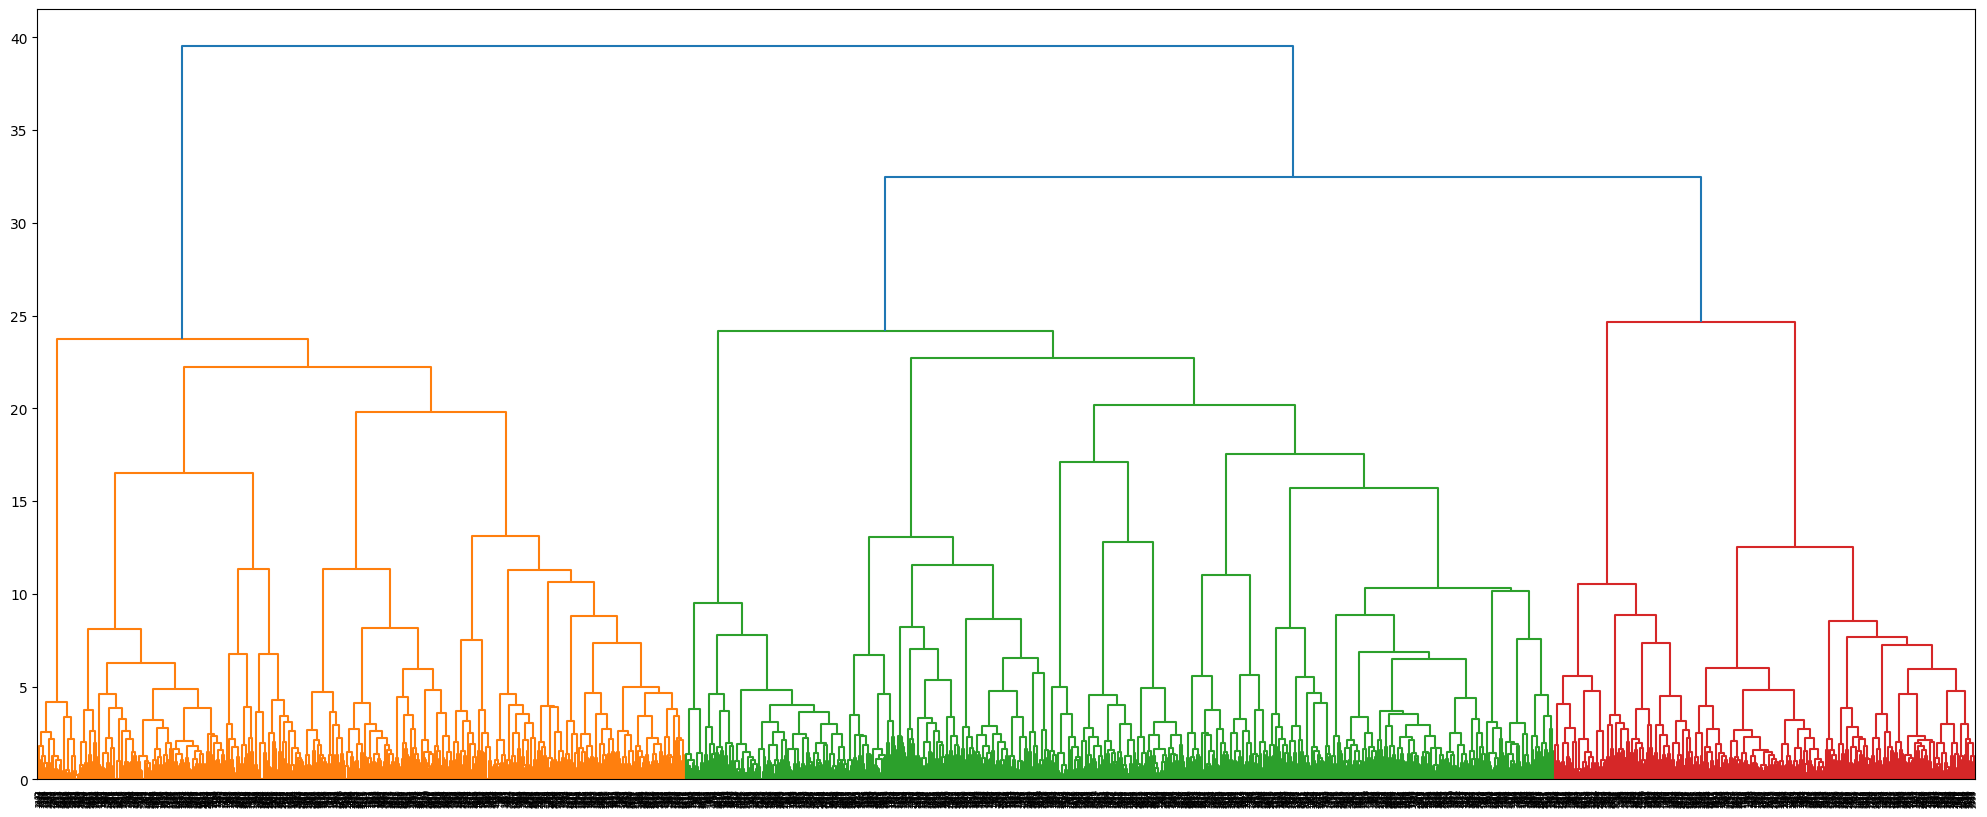

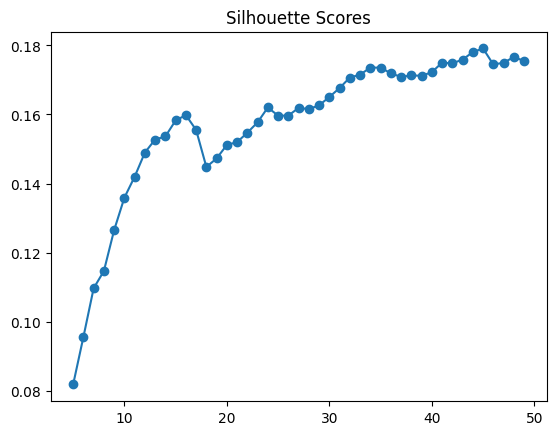

NMI: 0.24416558973982494


In [32]:
linkage_data_ward = perform_hierarchical_clustering(w2v_embeddings_all, "ward")

In [33]:
get_hierarchical_clusters(45, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 68
Sample Docs:=========
tyre separated
position tyre worn out
bent position guard
worn position tyre
punctured position tyre
position flat tyre
damaged position rim
flat tyre position
position and hub damaged
position tyre seperation

Top words:=========
position
tyre
damaged
damage
flat

Top failure modes:=========
damaged
damage
flat
blown
worn

Top equipment:=========
tyre
guard
rim
hub
wheel

Inherent functions in order:
guiding (56)
protecting (8)
holding (4)

Cluster 2 :
Cluster Size:========= 30
Sample Docs:=========
minor oil leak inside position rim
position turbo failed
coolant leak at position turbo
position brake hose leak
turbo coolant leak
position inside oil leak
CW failed position turbo
leak inside hub position /
position turbo bracket unserviceable
position turbo coolant leak

Top words:=========
position
leak
turbo
oil
inside

Top failure modes:=========
leak
failed
unserviceable
rotated
constant

Top equipment:=========
turbo
oil
c

## Approach 2: SBERT Clustering

In [21]:
SBERT_embeddings_all = sbert.encode(X_train+X_test)

### K-means Clustering

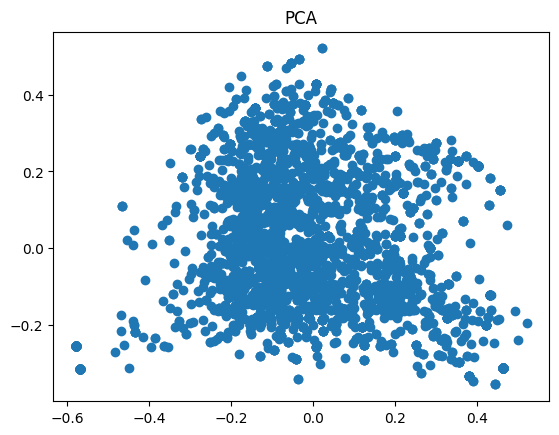

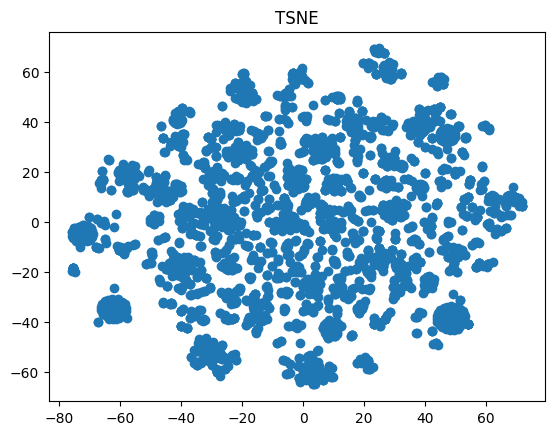

5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50


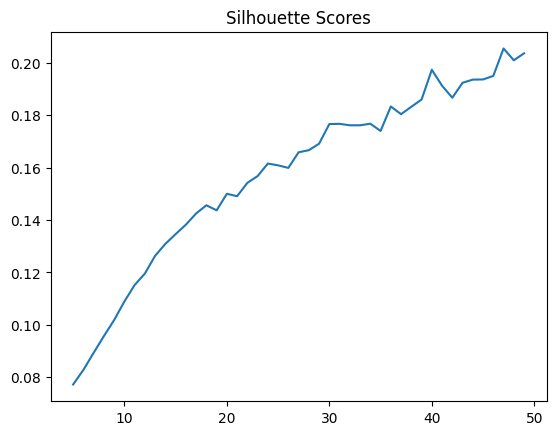

NMI: 0.14032983316765957


In [22]:
perform_kmeans(SBERT_embeddings_all)

In [35]:
run_kmeans_best_k(47, SBERT_embeddings_all)

Cluster 1 :
Cluster Size:========= 148
Sample Docs:=========
need to brake pads swing
house fans shutdown
filter fans not working
final drive oil samples required
vims keypad light is out

Top words:=========
unserviceable
out
needs
valve
light

Top failure modes:=========
unserviceable
worn
needs
missing
out

Top equipment:=========
control valve
vims keypad light
fan
house
fans

Inherent functions in order:
emitting (25)
controlling (21)
guiding (19)
protecting (15)
matterprocessing (15)
holding (14)
transforming (9)
generating (8)
covering (5)
storing (4)
humaninteraction (3)
driving (3)
sensing (3)
presenting (2)
interfacing (1)
restricting (1)

Cluster 2 :
Cluster Size:========= 45
Sample Docs:=========
aftercooler tank gauge broken
transmission hose leaks
cooler pump lube system has faults
parts washer pump pressure gauge not working
heater hose leaking

Top words:=========
hose
hoses
heater
pump
transmission

Top failure modes:=========
leaking
unserviceable
blown
not working
fa

### Average Hierarchical Clustering

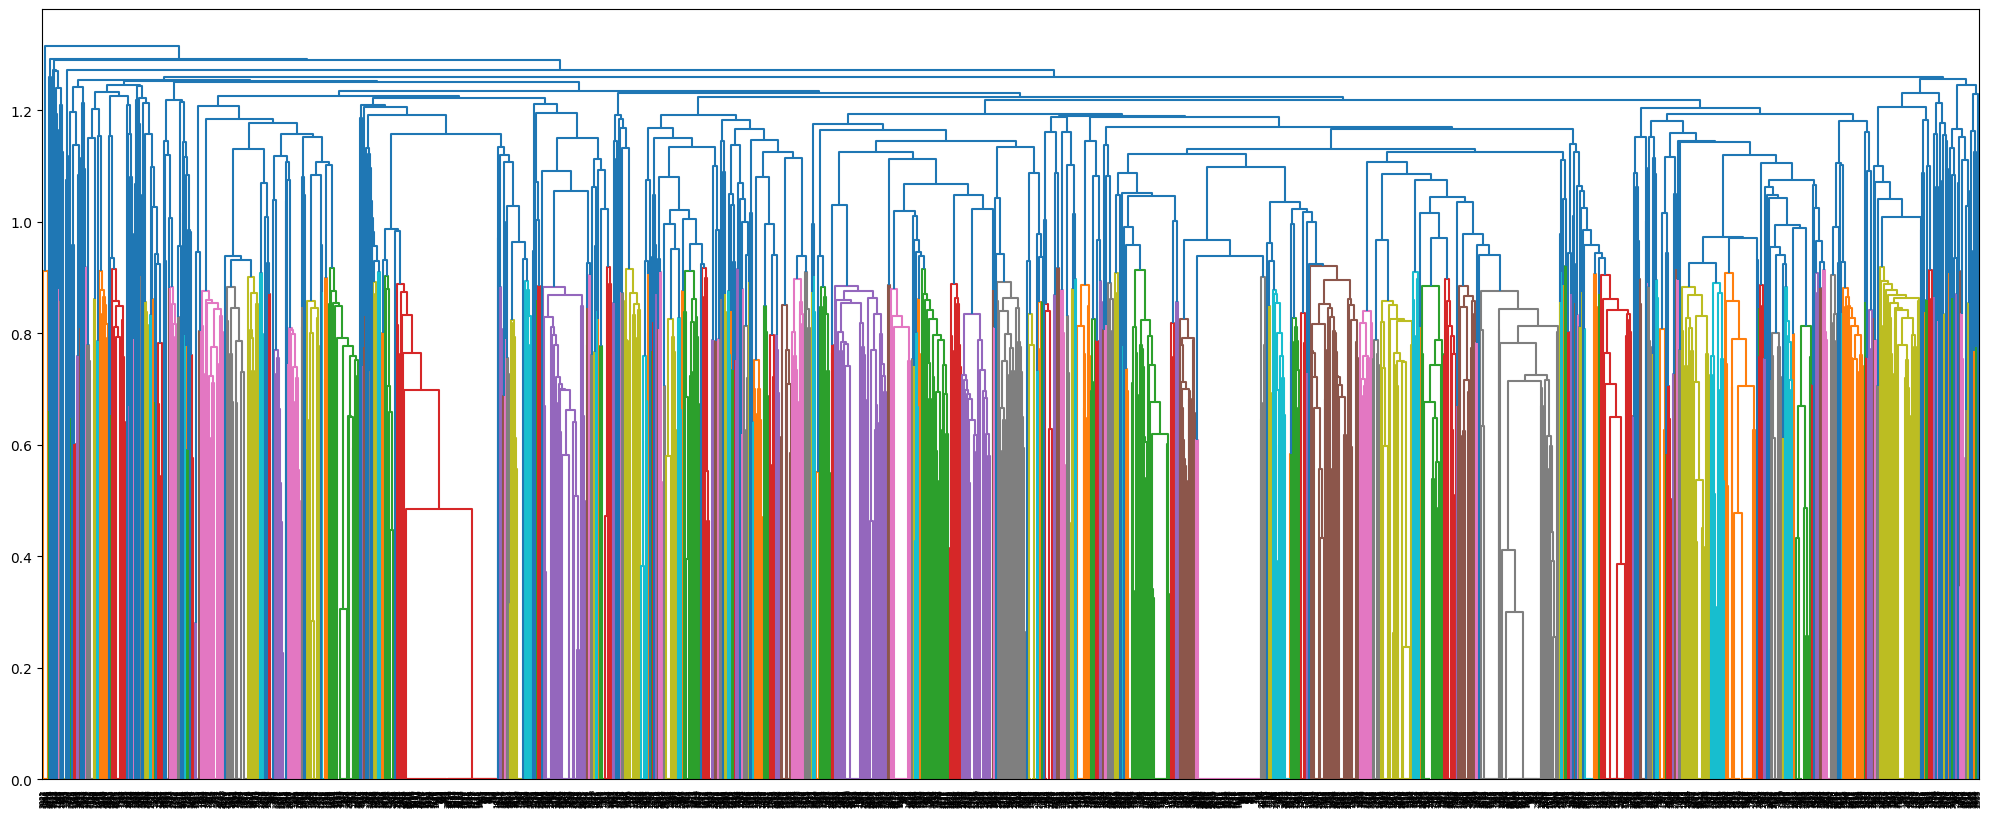

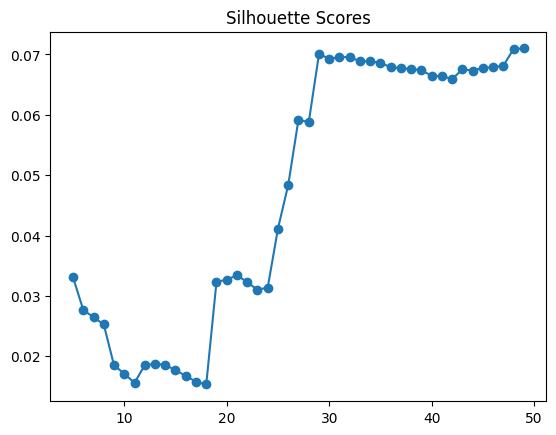

NMI: 0.06429959152061682


In [34]:
linkage_data_ave = perform_hierarchical_clustering(SBERT_embeddings_all, "average")

In [36]:
get_hierarchical_clusters(29, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 11
Sample Docs:=========
VIMS error
vims keypad light out
vims keypad light needs clean out
vims keypad light needs cleaning out
replace vims keypad light out
vims keypad light found out
VIMS keypad light out
VIMS keypad backlight blown
vims keypad light is out
vims keypad light remains out

Top words:=========
keypad
light
out
vims
VIMS

Top failure modes:=========
out
needs clean out
error
blown

Top equipment:=========
vims keypad light
VIMS
keypad
backlight
light

Inherent functions in order:
emitting (10)
presenting (1)

Cluster 2 :
Cluster Size:========= 2
Sample Docs:=========
PCR room air conditioner fault
PCR air conditioner wiring burnt out

Top words:=========
PCR
air
conditioner
wiring
burnt

Top failure modes:=========
burnt out
fault

Top equipment:=========
air conditioner
wiring

Inherent functions in order:
guiding (1)
emitting (1)

Cluster 3 :
Cluster Size:========= 4
Sample Docs:=========
environmental filter fittings oil leaks
cont

### Ward Hierarchical Clustering

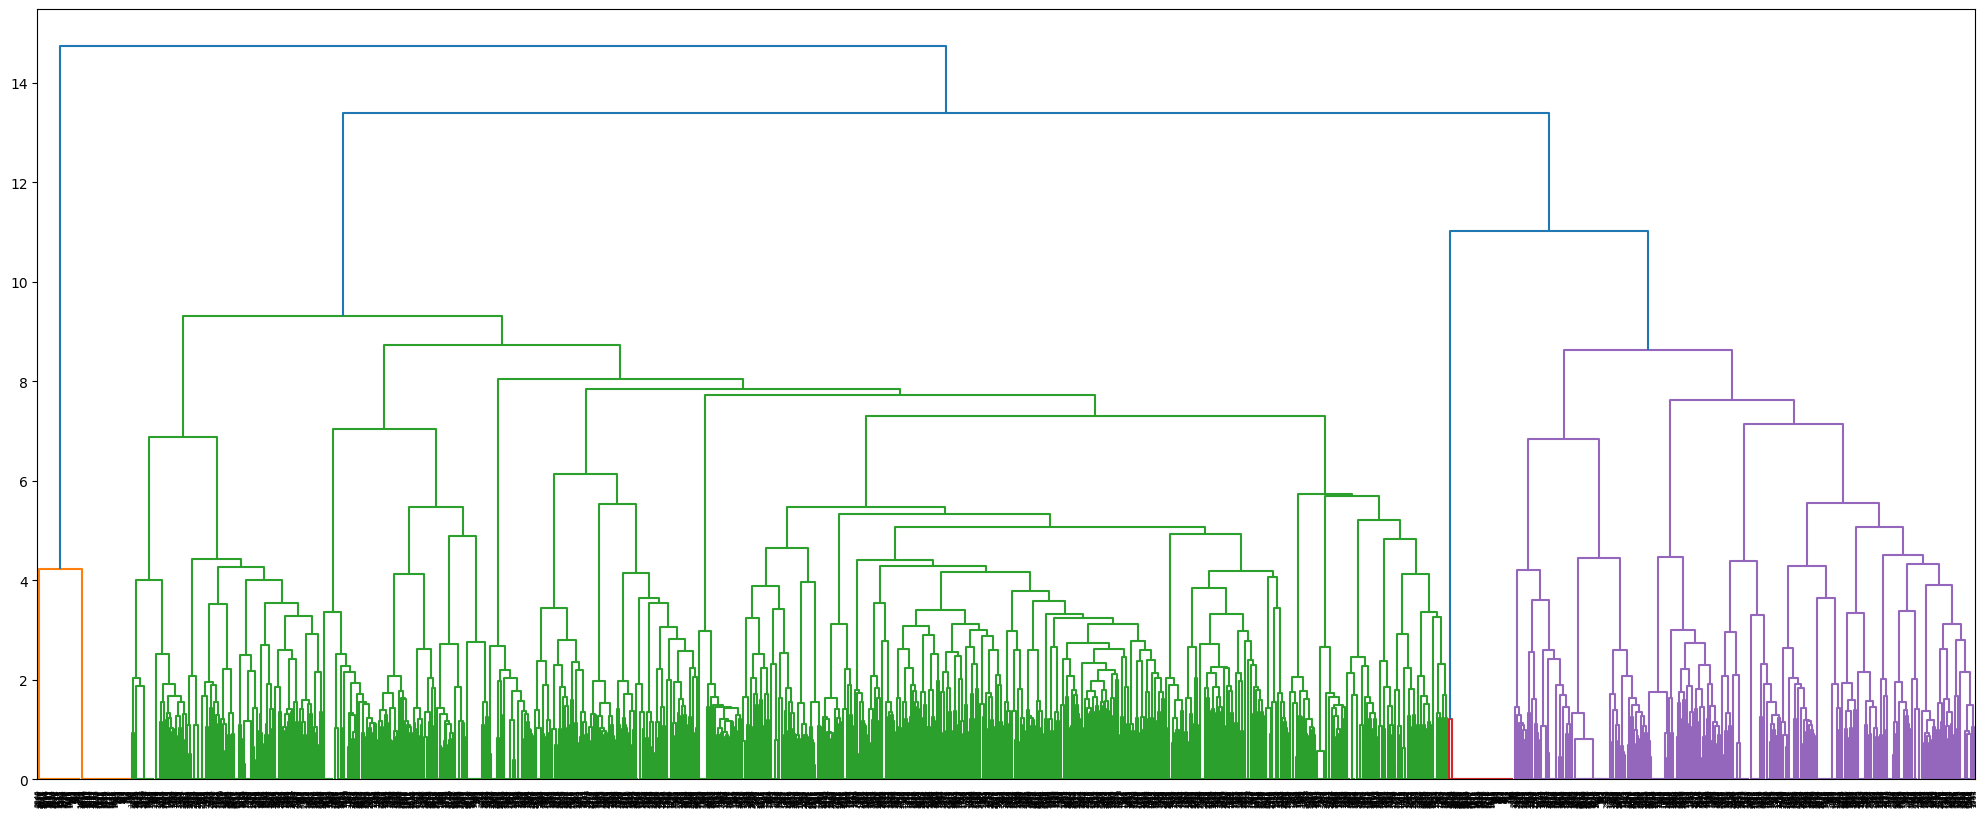

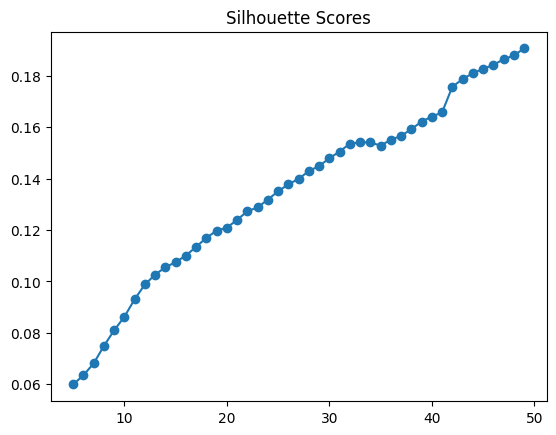

NMI: 0.13368412126460796


In [37]:
linkage_data_ward = perform_hierarchical_clustering(SBERT_embeddings_all, "ward")

In [38]:
get_hierarchical_clusters(49, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 70
Sample Docs:=========
left hand steering cylinder leaking
left hand bearing unserviceable
left hand front cam frame bolts loose
left hand rear module mount broken
left hand hoist cylinder fell off cylinder
left hand exhaust temperatures high reported
left hand side pinion cover cracking
left hand travel motor unserviceable
left hand side inner fairlead frame cracked at top
left hand front ramp cylinder mount cracked

Top words:=========
left
hand
side
unserviceable
rear

Top failure modes:=========
unserviceable
leaking
broken
loose
cracked

Top equipment:=========
cylinder
light
headlight
mount
chain

Inherent functions in order:
holding (23)
emitting (14)
guiding (13)
driving (7)
controlling (4)
storing (2)
protecting (2)
covering (2)
humaninteraction (1)
matterprocessing (1)
interfacing (1)

Cluster 2 :
Cluster Size:========= 82
Sample Docs:=========
right hand side mirror loose
right hand tooth missing
right hand armrest broken
right hand joyst

## Approach 3: Word2Vec Bi-LSTM Clustering

### Create Word2Vec Bi-LSTM Embeddings

In [23]:
w2v_if_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10,100)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(units=16, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

w2v_if_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = w2v_if_model.fit(w2v_embeddings_X_train, y_train, epochs=200, validation_data=(w2v_embeddings_X_test, y_test), callbacks=[early_stopping])

# run predictions
pred_train = w2v_if_model.predict(w2v_embeddings_X_train)
pred_train = pred_train.argmax(axis=-1)
print("Final train accuracy:", w2v_if_model.evaluate(w2v_embeddings_X_train, y_train)[1])

pred_test = w2v_if_model.predict(w2v_embeddings_X_test)
pred_test = pred_test.argmax(axis=-1)
print("Final test accuracy:", w2v_if_model.evaluate(w2v_embeddings_X_test, y_test)[1])

Epoch 1/200
79/79 [==============================] - 4s 15ms/step - loss: 2.5876 - accuracy: 0.2079 - val_loss: 2.3788 - val_accuracy: 0.3074
Epoch 2/200
79/79 [==============================] - 1s 7ms/step - loss: 2.1389 - accuracy: 0.3694 - val_loss: 2.0548 - val_accuracy: 0.4136
Epoch 3/200
79/79 [==============================] - 1s 7ms/step - loss: 1.8524 - accuracy: 0.4504 - val_loss: 1.8939 - val_accuracy: 0.4231
Epoch 4/200
79/79 [==============================] - 1s 7ms/step - loss: 1.6569 - accuracy: 0.5119 - val_loss: 1.7745 - val_accuracy: 0.5040
Epoch 5/200
79/79 [==============================] - 1s 7ms/step - loss: 1.5160 - accuracy: 0.5516 - val_loss: 1.6914 - val_accuracy: 0.5071
Epoch 6/200
79/79 [==============================] - 1s 7ms/step - loss: 1.4037 - accuracy: 0.5877 - val_loss: 1.6456 - val_accuracy: 0.5531
Epoch 7/200
79/79 [==============================] - 1s 7ms/step - loss: 1.2950 - accuracy: 0.6171 - val_loss: 1.5799 - val_accuracy: 0.5658
Epoch 8/200


In [52]:
w2v_if_model_embedding = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10,100)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu')
])

w2v_if_model_embedding.layers[0].set_weights(w2v_if_model.layers[0].get_weights())
w2v_if_model_embedding.layers[1].set_weights(w2v_if_model.layers[1].get_weights())
w2v_if_model_embedding.layers[2].set_weights(w2v_if_model.layers[2].get_weights())
w2v_if_model_embedding.layers[3].set_weights(w2v_if_model.layers[3].get_weights())

w2v_embeddings = np.concatenate((w2v_embeddings_X_train, w2v_embeddings_X_test))
cluster_embeddings = w2v_if_model_embedding.predict(w2v_embeddings)
print(cluster_embeddings.shape)

99/99 [==============================] - 1s 3ms/step
(3151, 10)


### K-means Clustering

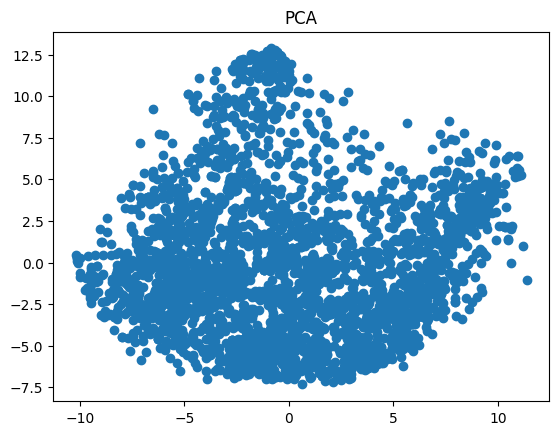

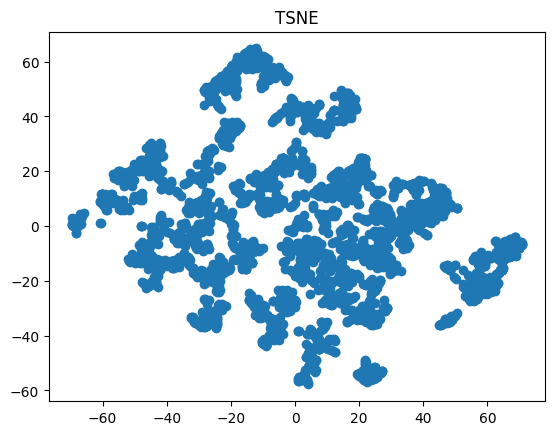

5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50


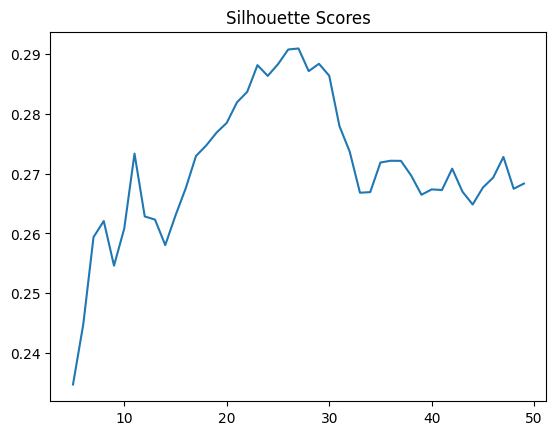

NMI: 0.4813967652291494


In [25]:
perform_kmeans(cluster_embeddings)

In [40]:
run_kmeans_best_k(27, cluster_embeddings)

Cluster 1 :
Cluster Size:========= 131
Sample Docs:=========
IOV fault on drag package
engine radiator leaking
generator set has control wiring fault number
not working compressor
hoist resolver fault

Top words:=========
compressor
air
pump
unserviceable
conditioner

Top failure modes:=========
unserviceable
not working
leaking
fault
leak

Top equipment:=========
compressor
pump
air conditioner
generator
water pump

Inherent functions in order:
generating (100)
driving (6)
restricting (5)
guiding (5)
emitting (3)
storing (2)
presenting (2)
holding (2)
interfacing (2)
matterprocessing (1)
protecting (1)
sensing (1)
controlling (1)

Cluster 2 :
Cluster Size:========= 49
Sample Docs:=========
boom hose o-ring blown
transmission hose o-ring is blown
engine pump o-ring blown
blown o-ring radiator
blown o-ring on left hand lift cylinder

Top words:=========
blown
o-ring
hose
pump
air

Top failure modes:=========
blown
leaking
weeping
unserviceable
loose

Top equipment:=========
o-ring
hose


### Average Hierarchical Clustering

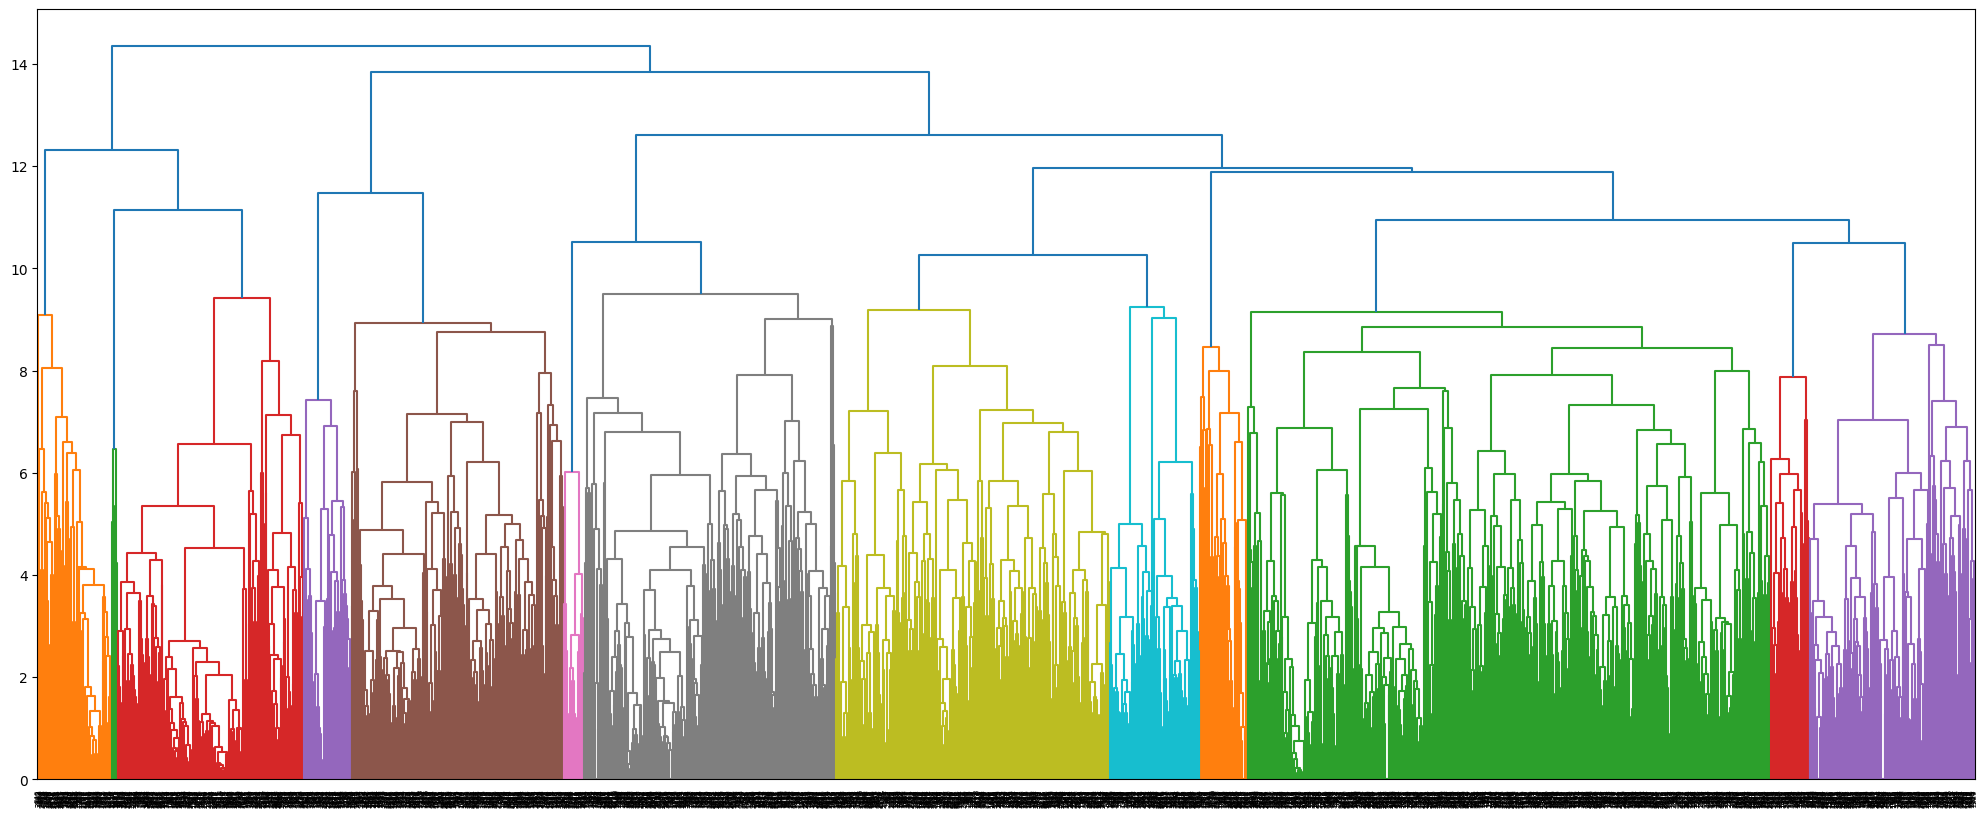

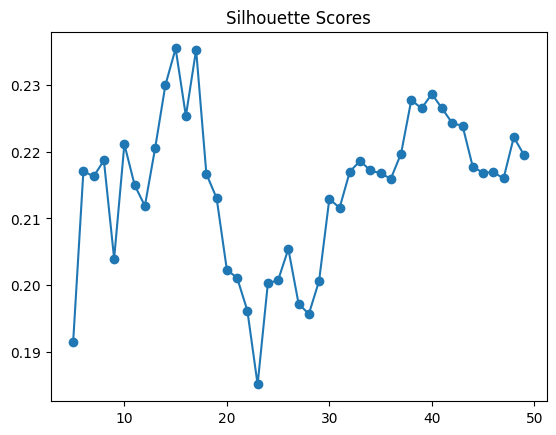

NMI: 0.4463444737280728


In [53]:
linkage_data_ave = perform_hierarchical_clustering(cluster_embeddings, "average")

In [42]:
get_hierarchical_clusters(15, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 121
Sample Docs:=========
battery unserviceable
alternator overcharge fault
batteries have no charge
blower inverter batteries are not charging
inverter batteries showing no charge
position turbo cartridge clamp failed
batteries unserviceable
compressor tripped
battery cell is dropped
dropped cell in battery

Top words:=========
batteries
no
charge
inverter
battery

Top failure modes:=========
no charge
unserviceable
dropped cell
failed
leak

Top equipment:=========
batteries
battery
fan
turbo
inverter batteries

Inherent functions in order:
generating (84)
holding (14)
storing (13)
guiding (5)
covering (1)
sensing (1)
interfacing (1)
transforming (1)
controlling (1)

Cluster 2 :
Cluster Size:========= 9
Sample Docs:=========
lost drive noisy front drop box
tray coming down hard
evaporator fans getting noisy
right hand boom cylinder leaking heavily PO
no reception on AM / FM radio
hoist blower tripping out
left hand boom cylinder hose leaking PO
/ noi

### Ward Hierarchical Clustering

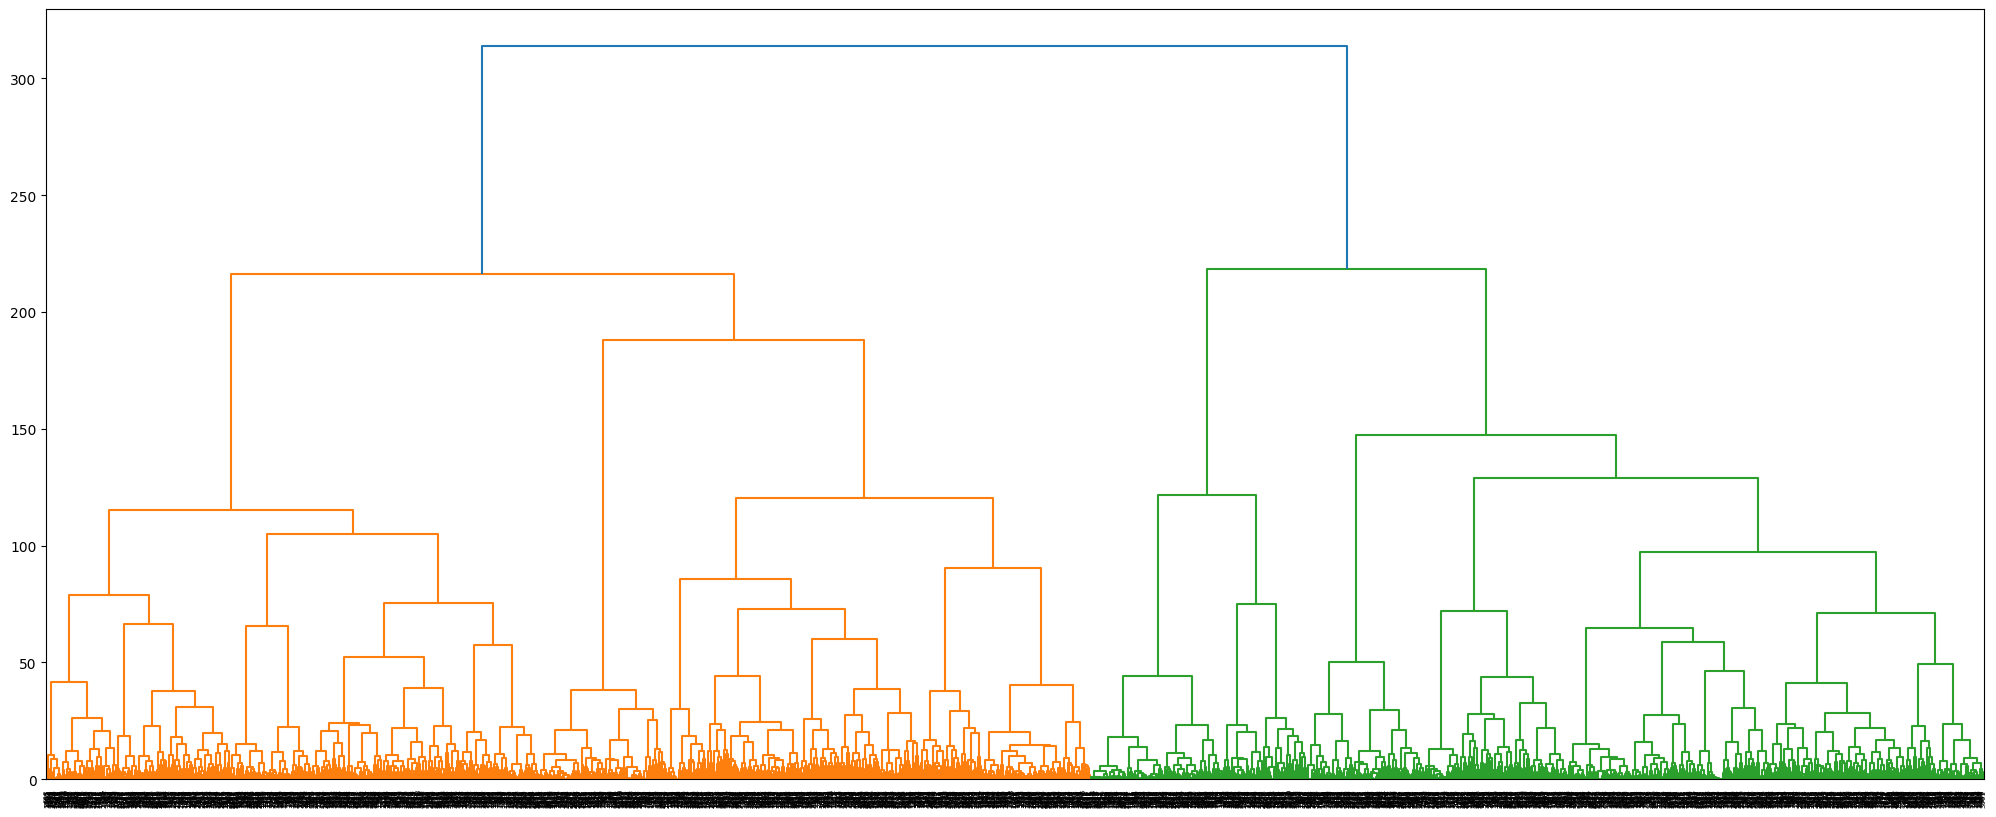

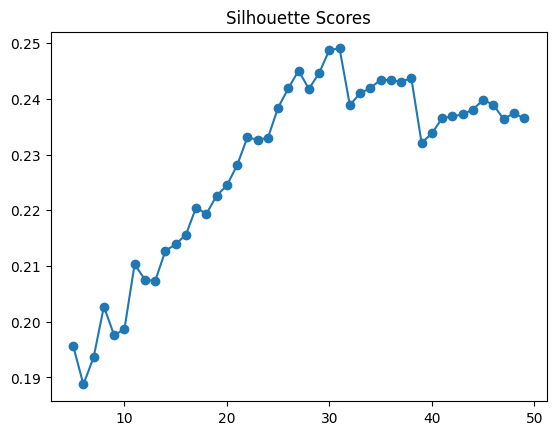

NMI: 0.4650191380196757


In [43]:
linkage_data_ward = perform_hierarchical_clustering(cluster_embeddings, "ward")

In [44]:
get_hierarchical_clusters(31, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 115
Sample Docs:=========
replace cabin seat needed
mud bucket has cracks
steering wheel cover missing
cabin seat requires loctite
repair cracks on mud bucket
broken handrail weld
cracked fuel tank
cracks top of bucket
fuel tank crack
air tank safety valve needs replacement faulty

Top words:=========
tank
seat
fuel
cabin
cracked

Top failure modes:=========
cracked
crack
cracks
leak
missing

Top equipment:=========
tank
fuel tank
cabin seat
mud bucket
seat

Inherent functions in order:
storing (70)
covering (20)
guiding (11)
holding (5)
protecting (3)
controlling (2)
interfacing (2)
restricting (1)
sensing (1)

Cluster 2 :
Cluster Size:========= 33
Sample Docs:=========
blown o-ring on implement hose
blown o-ring
blown boom hose o-ring
blown o-ring on left hand lift cylinder
blown o-ring on steering hose
blown o-ring
engine pump o-ring blown
blown o-ring in air conditioner hose
blown transmission hydraulic hose
blown o-ring on steering pump

Top word

## Approach 4: SBERT NN Clustering

### Create SBERT NN Embeddings

In [26]:
sbert_if_model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=128, activation="tanh", input_shape=(768,)),
    tf.keras.layers.Dense(units=64, activation="tanh"),
    tf.keras.layers.Dense(units=32, activation="tanh"),

    tf.keras.layers.Dense(units=10, activation="tanh"),
    tf.keras.layers.Dense(units=16, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

sbert_if_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = sbert_if_model.fit(SBERT_embeddings_train, y_train, epochs=200, validation_data=(SBERT_embeddings_test, y_test), callbacks=[early_stopping])

# do predictions
pred_train = sbert_if_model.predict(SBERT_embeddings_train)
pred_train = pred_train.argmax(axis=-1)
print("training accuracy", sbert_if_model.evaluate(SBERT_embeddings_train, y_train)[1])

pred_test = sbert_if_model.predict(SBERT_embeddings_test)
pred_test = pred_test.argmax(axis=-1)
print("test accuracy", sbert_if_model.evaluate(SBERT_embeddings_test, y_test)[1])


Epoch 1/200
79/79 [==============================] - 1s 4ms/step - loss: 2.4830 - accuracy: 0.2476 - val_loss: 2.3253 - val_accuracy: 0.3281
Epoch 2/200
79/79 [==============================] - 0s 4ms/step - loss: 2.1294 - accuracy: 0.3988 - val_loss: 2.1567 - val_accuracy: 0.3946
Epoch 3/200
79/79 [==============================] - 0s 2ms/step - loss: 1.9278 - accuracy: 0.4675 - val_loss: 2.0279 - val_accuracy: 0.4279
Epoch 4/200
79/79 [==============================] - 0s 2ms/step - loss: 1.7843 - accuracy: 0.5123 - val_loss: 1.9312 - val_accuracy: 0.4754
Epoch 5/200
79/79 [==============================] - 0s 2ms/step - loss: 1.6741 - accuracy: 0.5571 - val_loss: 1.9024 - val_accuracy: 0.4802
Epoch 6/200
79/79 [==============================] - 0s 2ms/step - loss: 1.5754 - accuracy: 0.5849 - val_loss: 1.8365 - val_accuracy: 0.5040
Epoch 7/200
79/79 [==============================] - 0s 2ms/step - loss: 1.5087 - accuracy: 0.5893 - val_loss: 1.7965 - val_accuracy: 0.5103
Epoch 8/200
7

In [54]:
# get hidden layer model 
sbert_if_model_embedding = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=128, activation="tanh", input_shape=(768,)),
    tf.keras.layers.Dense(units=64, activation="tanh"),
    tf.keras.layers.Dense(units=32, activation="tanh"),

    tf.keras.layers.Dense(units=10, activation="tanh"),
])


sbert_if_model_embedding.layers[0].set_weights(sbert_if_model.layers[0].get_weights())
sbert_if_model_embedding.layers[1].set_weights(sbert_if_model.layers[1].get_weights())
sbert_if_model_embedding.layers[2].set_weights(sbert_if_model.layers[2].get_weights())
sbert_if_model_embedding.layers[3].set_weights(sbert_if_model.layers[3].get_weights())


SBERT_embeddings = np.concatenate((SBERT_embeddings_train, SBERT_embeddings_test))
cluster_embeddings = sbert_if_model_embedding.predict(SBERT_embeddings)
print(cluster_embeddings.shape)


99/99 [==============================] - 0s 587us/step
(3151, 10)


### K-means Clustering

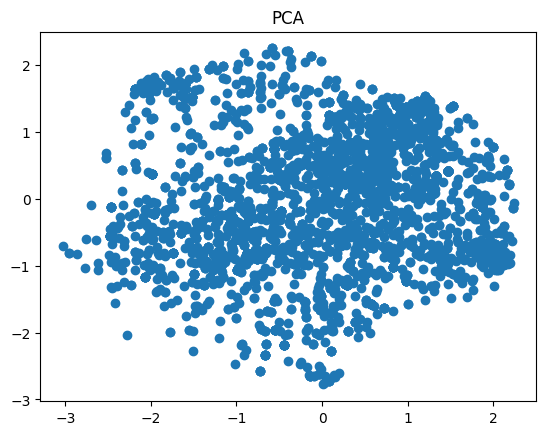

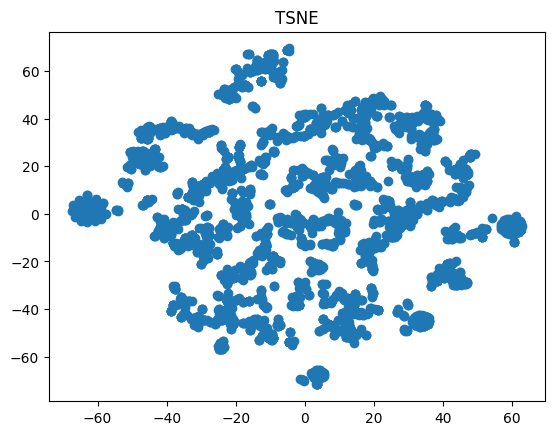

5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50


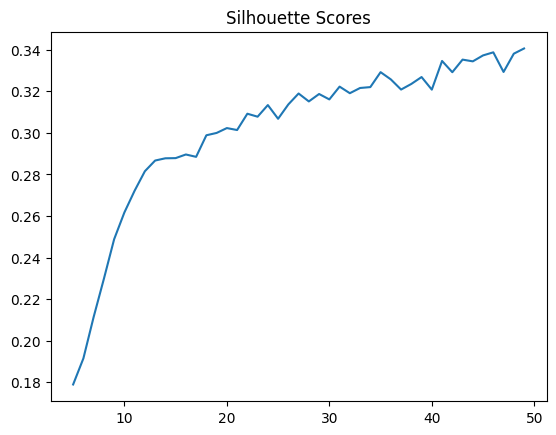

NMI: 0.4273029011538939


In [28]:
perform_kmeans(cluster_embeddings)

In [55]:
run_kmeans_best_k(49, cluster_embeddings)

Cluster 1 :
Cluster Size:========= 42
Sample Docs:=========
cracked glass in entry door
ladder fault
damaged ladder
ladder faulty on raising
damaged glass

Top words:=========
ladder
glass
on
damaged
fault

Top failure modes:=========
damaged
fault
cracked
worn
unserviceable

Top equipment:=========
ladder
glass
dogbone
coupling
fitting

Inherent functions in order:
interfacing (33)
restricting (2)
holding (2)
guiding (2)
controlling (2)
matterprocessing (1)

Cluster 2 :
Cluster Size:========= 81
Sample Docs:=========
dragline air conditioner needs to change out
cracked rear window
thrust bearing oil discovered
needs repair for engine air conditioner
dragline air conditioner needs change out

Top words:=========
leak
coolant
oil
hydraulic
engine

Top failure modes:=========
leak
needs repair
cracked
found
need

Top equipment:=========
coolant
hydraulic oil
engine
mast dust flap
oil

Inherent functions in order:
protecting (57)
emitting (9)
guiding (4)
storing (2)
covering (2)
restricti

### Average Hierachical Clustering

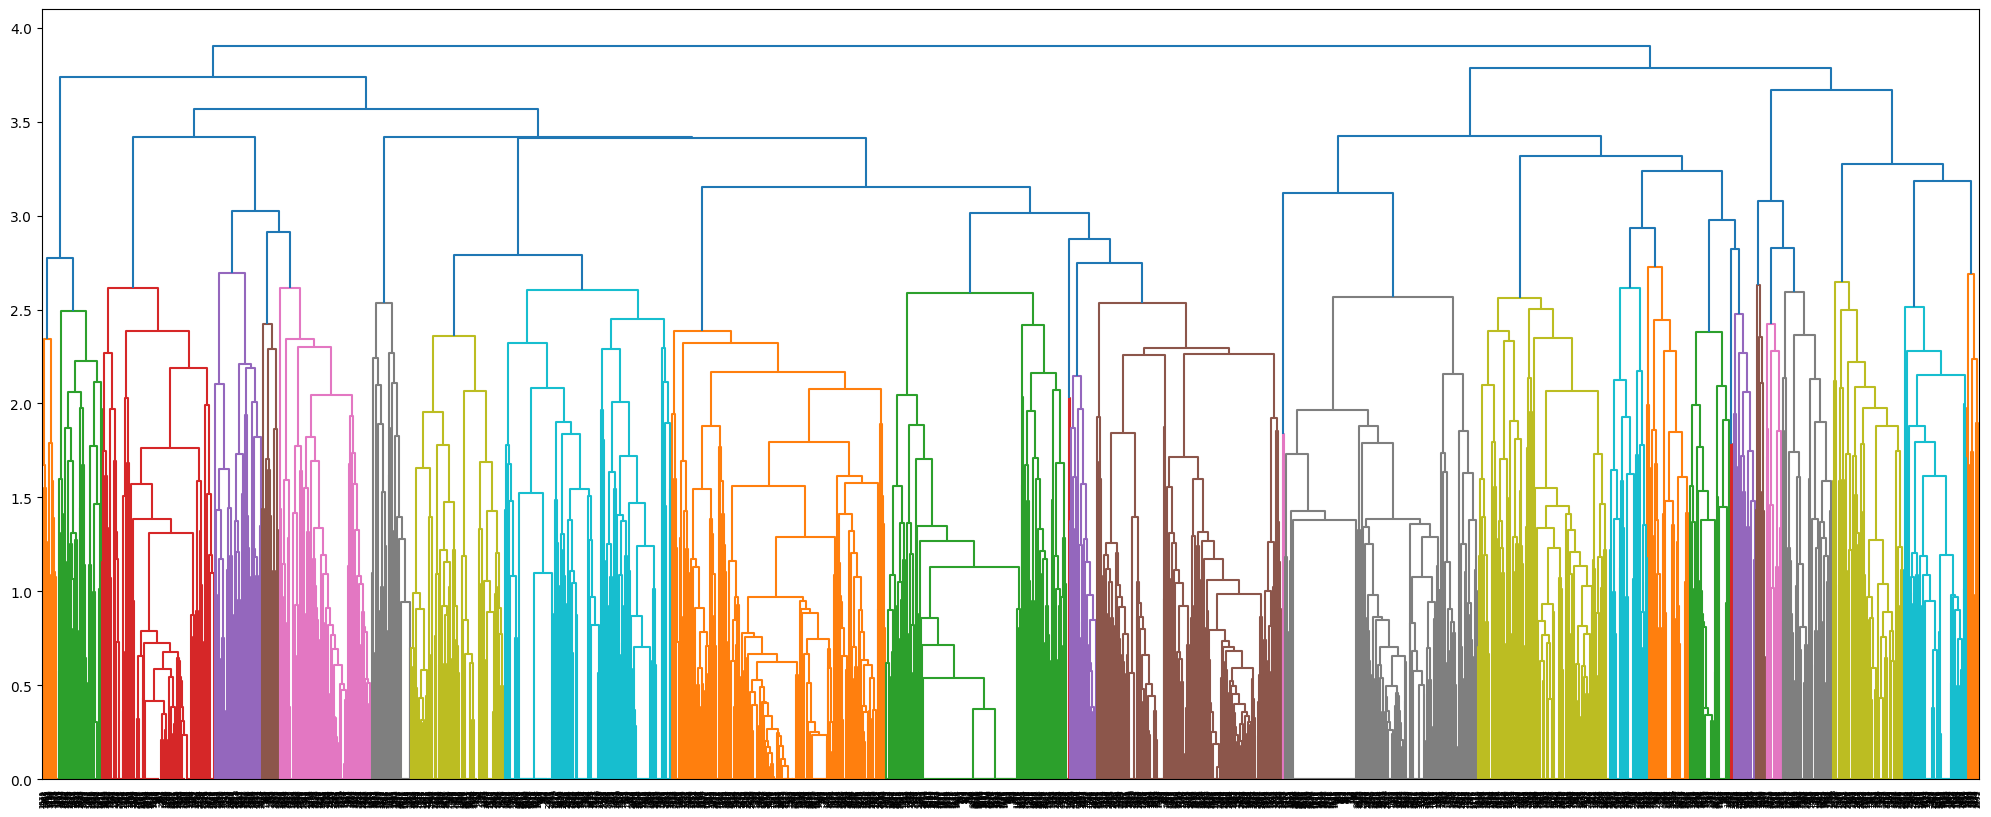

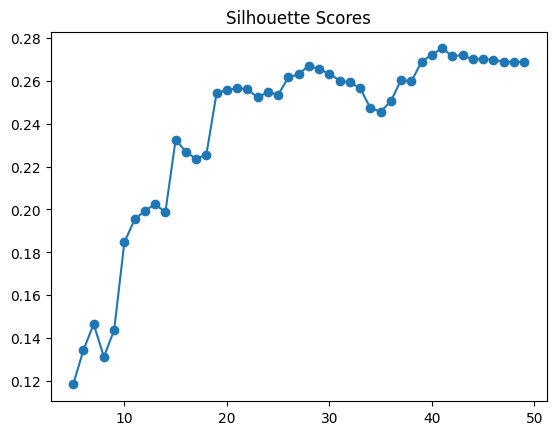

NMI: 0.40947337910223275


In [48]:
linkage_data_ave = perform_hierarchical_clustering(cluster_embeddings, "average")

In [49]:
get_hierarchical_clusters(41, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 27
Sample Docs:=========
short in headlight wiring
mud bucket cutting edge required
dirt and water entry final drive
missing bucket tooth
mud bucket has cracks
bucket requested
mud bucket is cracked
leaking scavenge pump
missing bucket studs
ladder leaking oil

Top words:=========
bucket
in
mud
missing
power

Top failure modes:=========
missing
cracks
no power
fault
leaking

Top equipment:=========
bucket
mud bucket
cabin
tooth
oil

Inherent functions in order:
storing (8)
holding (8)
matterprocessing (4)
interfacing (2)
guiding (2)
transforming (1)
sensing (1)
generating (1)

Cluster 2 :
Cluster Size:========= 71
Sample Docs:=========
grease fitting coupling unserviceable
tooth missing
missing GET
worn teeth
tooth off bucket
ripper shank broken
bucket cutting edges loose
cracked blade liner
plugged fuel filters
drag iov has a fault

Top words:=========
bucket
worn
cutting
loose
edges

Top failure modes:=========
worn
loose
missing
blocked
broken

Top

### Ward Hierarchical Clustering

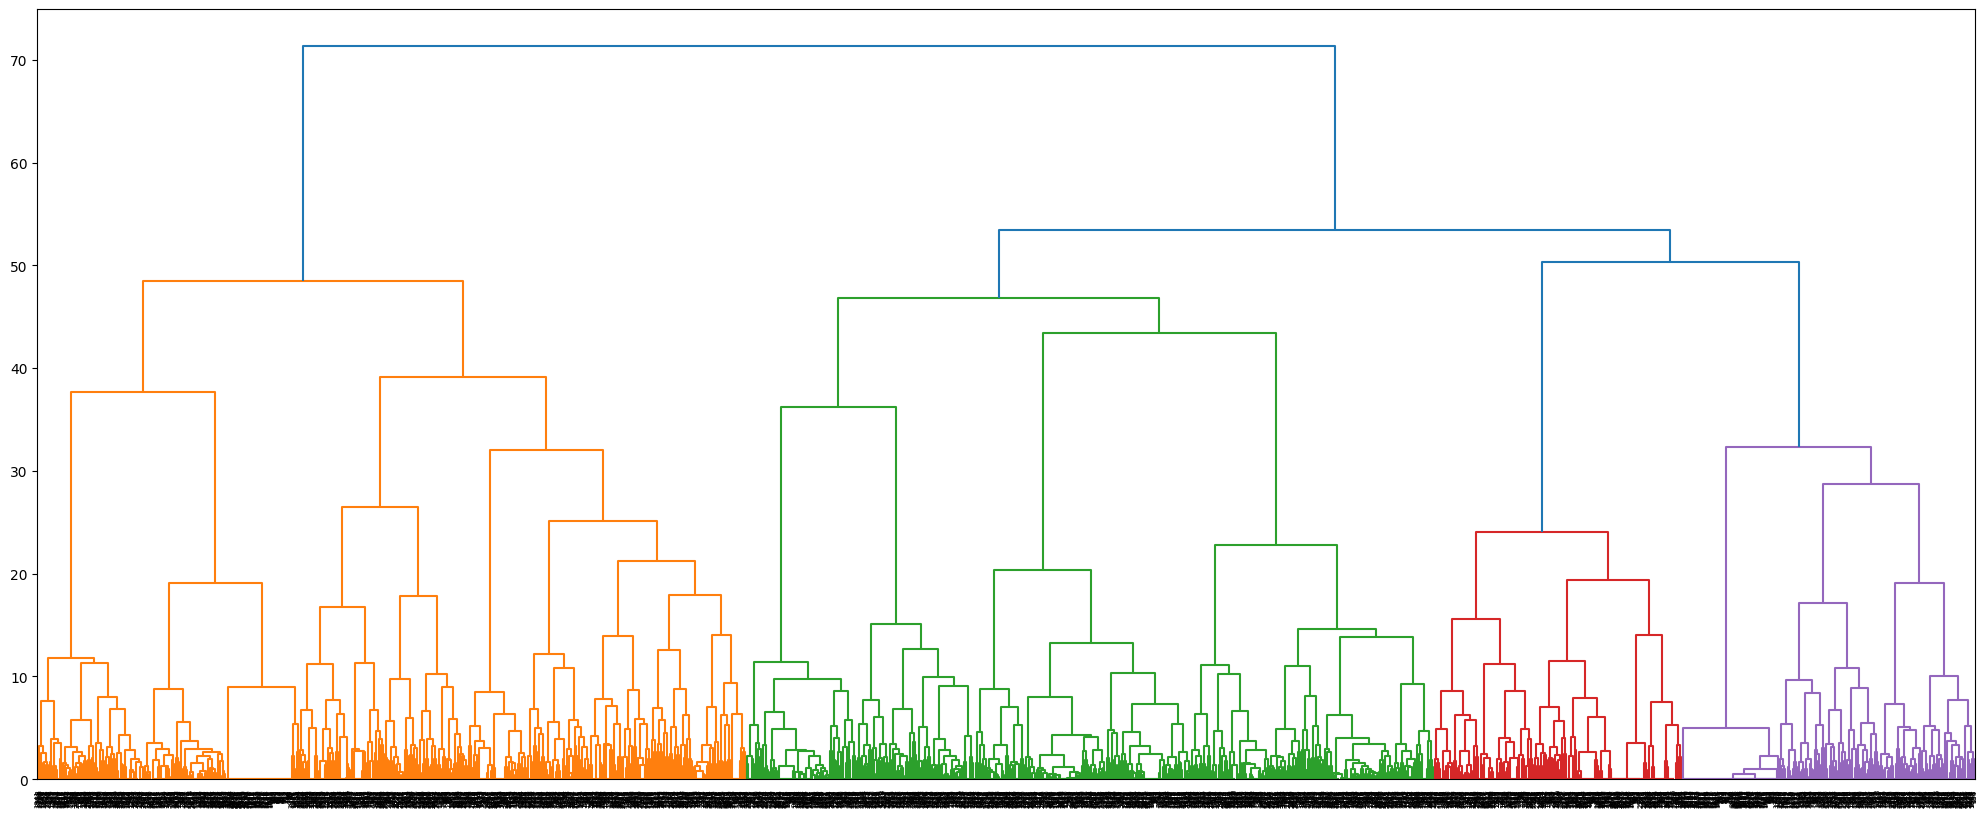

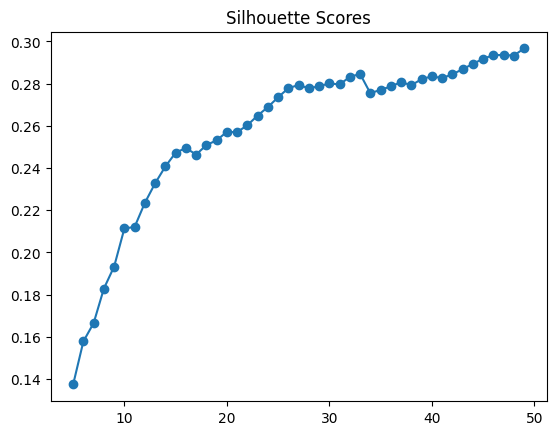

NMI: 0.40878215624726


In [50]:
linkage_data_ward = perform_hierarchical_clustering(cluster_embeddings, "ward")

In [51]:
get_hierarchical_clusters(49, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 41
Sample Docs:=========
number injector error
implement pump oil leak
battery unserviceable dropped cell
no excitation on hoist
grease pump is bypassing air
environmental spray filter blocked PO's
constant voltage transformer melted
battery unserviceable
auxiliary water pump leaking
dry cell not working properly

Top words:=========
pump
not
working
grease
unserviceable

Top failure modes:=========
not working
unserviceable
leaking
dropped cell
error

Top equipment:=========
pump
grease pump
battery
auto-spray
compressor

Inherent functions in order:
generating (29)
storing (4)
protecting (2)
matterprocessing (1)
covering (1)
transforming (1)
interfacing (1)
driving (1)
holding (1)

Cluster 2 :
Cluster Size:========= 51
Sample Docs:=========
auto-greaser unserviceable
unserviceable compressor
compressor will not start
air compressor will not start
alternator failed
alternator overcharged
x failed condensor fans
inverter keeps earthing out
compressor 